In [1]:
import pandas as pd
from pathlib import Path

In [2]:
data_dir = Path("../data/docanno")
full_dataset_path = data_dir / "docanno.csv"
train_path = data_dir / "train.csv"
val_path = data_dir / "val.csv"
test_path = data_dir / "test.csv"

In [3]:
full_df = pd.read_csv(full_dataset_path)
train_or_df = pd.read_csv(train_path)
val_or_df = pd.read_csv(val_path)
test_or_df = pd.read_csv(test_path)
full_df.shape, full_df.columns, train_or_df.columns

((176448, 27),
 Index(['text_id', 'user_id', 'inspiring', 'interesting',
        'offensive_to_someone', 'negative', 'offensive_to_me', 'political',
        'positive', 'sadness', 'calm', 'fear', 'compassion', 'disgust',
        'vulgar', 'surprise', 'embarrasing', 'anger', 'understandable',
        'ironic', 'need_more_information', 'happiness', 'delight',
        'funny_to_someone', 'funny_to_me', 'fold', 'text'],
       dtype='object'),
 Index(['text_id', 'user_id', 'inspiring', 'interesting',
        'offensive_to_someone', 'negative', 'offensive_to_me', 'political',
        'positive', 'sadness', 'calm', 'fear', 'compassion', 'disgust',
        'vulgar', 'surprise', 'embarrasing', 'anger', 'understandable',
        'ironic', 'need_more_information', 'happiness', 'delight',
        'funny_to_someone', 'funny_to_me', 'fold', 'text'],
       dtype='object'))

In [4]:
train_or_df.shape[0], val_or_df.shape[0], test_or_df.shape[0], train_or_df.shape[0] + val_or_df.shape[0] + test_or_df.shape[0]

(127856, 15849, 16306, 160011)

In [5]:
full_df.drop_duplicates(subset=["text_id"]).shape

(39737, 27)

In [6]:
datasets = [train_or_df, val_or_df, test_or_df]
t1 = datasets[0].drop_duplicates(subset=["text_id"])
v1 = datasets[1].drop_duplicates(subset=["text_id"])
d1 = datasets[2].drop_duplicates(subset=["text_id"])
print(t1.shape[0], v1.shape[0], d1.shape[0])
print(t1.shape[0] + v1.shape[0] + d1.shape[0])
f = pd.concat([t1, v1, d1], axis=0)
print(f.shape[0])
print(f.drop_duplicates(subset=["text_id"]).shape[0])
d2 = d1[~d1["text_id"].isin(t1["text_id"])]
v2 = v1[(~v1["text_id"].isin(t1["text_id"]))] # & (~v1["text_id"].isin(d2["text_id"]))]
f2 = pd.concat([t1, v2, d2], axis=0)
print(f2.shape[0])
print(f2.drop_duplicates(subset=["text_id"]).shape[0])

29350 373 8989
38712
38712
38712
38712
38712


In [7]:
def transform_and_clean_empty_annotations(df):
    
    label_columns = sorted([
        'inspiring', 'interesting',
        'offensive_to_someone', 'negative', 'offensive_to_me', 'political',
        'positive', 'sadness', 'calm', 'fear', 'compassion', 'disgust',
        'vulgar', 'surprise', 'embarrasing', 'anger', 'understandable',
        'ironic', 'need_more_information', 'happiness', 'delight',
        'funny_to_someone', 'funny_to_me'
    ])

    df[label_columns] = df[label_columns].replace(-1, 0).replace(list(range(1,11)), 1)
    
    def is_empty(sample):
        sum_ = sum([sample[label] for label in label_columns])
        empty = False
        if sum_ == 0:
            empty = True
        return empty

    df["empty"] = df.apply(is_empty, axis=1)
    df = df[~df["empty"]]
    return df.drop(columns=["empty"])
    

In [8]:
full_df_cleaned = transform_and_clean_empty_annotations(full_df)
full_df_cleaned.shape, full_df.shape, full_df.head()

((168236, 27),
 (176448, 28),
    text_id  user_id  inspiring  interesting  offensive_to_someone  negative  \
 0        0        0          1            1                     1         1   
 1        0        1          1            1                     1         1   
 2        0        2          1            1                     1         1   
 3        0        3          1            1                     1         1   
 4        0        4          1            1                     1         1   
 
    offensive_to_me  political  positive  sadness  ...  understandable  ironic  \
 0                1          1         1        1  ...               1       0   
 1                1          1         1        1  ...               1       1   
 2                1          1         1        1  ...               1       1   
 3                1          1         1        1  ...               1       1   
 4                1          1         1        1  ...               1       0

In [9]:
train_texts = t1["text_id"]
test_texts = d2["text_id"]
val_texts = v2["text_id"]
new_train = full_df_cleaned[full_df_cleaned["text_id"].isin(train_texts)]
new_test = full_df_cleaned[full_df_cleaned["text_id"].isin(test_texts)]
new_val = full_df_cleaned[full_df_cleaned["text_id"].isin(val_texts)]

new_train.shape, new_val.shape, new_test.shape

((134772, 27), (17158, 27), (16306, 27))

In [10]:
def check_users(train, test, dev):
    train_users = train["user_id"].unique()
    dev_users = dev["user_id"].unique()
    test_users = test["user_id"].unique()
    print("sizes -", "train:", train_users.shape, "val:", dev_users.shape, "test:", test_users.shape)
    train_dev = (len(set(train_users) - set(dev_users)), len(set(dev_users) - set(train_users)))
    train_test = (len(set(train_users) - set(test_users)), len(set(test_users) - set(train_users)))
    test_dev = (len(set(test_users) - set(dev_users)), len(set(dev_users) - set(test_users)))
    print(train_dev, train_test, test_dev)
    print(set(train_users) - set(test_users))

In [11]:
check_users(new_train, new_test, new_val)

sizes - train: (60,) val: (60,) test: (53,)
(0, 0) (7, 0) (0, 7)
{37, 40, 19, 20, 52, 55, 27}


In [12]:
def clean_users(new_train, new_val, new_test):
    in_test = new_train[new_train["user_id"].isin(new_test["user_id"])]
    in_both = in_test[in_test["user_id"].isin(new_val["user_id"])]
    dev_both = new_val[new_val["user_id"].isin(in_both["user_id"])]
    test_both = new_test[new_test["user_id"].isin(in_both["user_id"])]
    print(in_both.shape, dev_both.shape, test_both.shape)
    return in_both, dev_both, test_both

In [13]:
in_both, dev_both, test_both = clean_users(new_train, new_val, new_test)

(127856, 27) (15849, 27) (16306, 27)


In [14]:
check_users(in_both, test_both, dev_both)

sizes - train: (53,) val: (53,) test: (53,)
(0, 0) (0, 0) (0, 0)
set()


In [15]:
def average_annotation_per_user(df, crop=False):
    annotation_number = df.groupby(by=["user_id"]).count()["text_id"].sort_values()
    print("annotator head")
    print(annotation_number.head())
    print("annotator tail")
    print(annotation_number.tail())
    mean = annotation_number.mean()
    max = annotation_number.max()
    min = annotation_number.min()
    median = annotation_number.median()
    (annotation_number/max).reset_index()["text_id"].plot()
    all = df.shape[0]
    upper_threshold = 0.8*max
    lower_threshold = 0.01*max
    print("ANNOTATORS")
    print("min:", min, "mean:", mean, "median:", median ,"max:", max, "all:", all)
    text_number = df.groupby(by=["text_id"]).count()["user_id"].sort_values()
    # print("text head")
    # print(text_number.head())
    # print("text tail")
    # print(text_number.tail())
    mean = text_number.mean()
    max = text_number.max()
    min = text_number.min()
    median = text_number.median()
    # (text_number/max).reset_index()["user_id"].plot()
    all = df.shape[0]
    print("TEXTS")
    print("min:", min, "mean:", mean, "median:", median ,"max:", max, "all:", all)    
    curr_df = df
    if crop:
        print("cropping...")
        print(curr_df.shape)
        to_crop = []
        for worker in df["user_id"].unique():
            if annotation_number[worker] < lower_threshold:
                curr_df = curr_df[curr_df["user_id"] != worker]
            if annotation_number[worker] > upper_threshold:
                to_crop.append(worker)
        print("after lower crop, before upper")
        print(curr_df.shape)
        for worker in to_crop:
            crop_number = int(annotation_number[worker] - upper_threshold)
            ann_to_drop = curr_df[curr_df["user_id"] == worker].sample(n=crop_number)
            anns = pd.merge(curr_df, ann_to_drop, how="outer", indicator=True)
            curr_df = anns[anns["_merge"] == "left_only"].drop(columns=["_merge"], axis=1)
        print("cropping finished...")
        print(curr_df.shape)
    
    return curr_df.dropna()

In [16]:
def change_id_to_int(df):
    df["user_id"] = df["user_id"].astype(int)
    return df

In [17]:
def analyze_annotations(train, dev, test, crop=False):
    print('-'*10, 'check', "-"*10)
    check_users(train, test, dev)
    print('-'*10, 'clean', "-"*10)
    in_both, dev_both, test_both = clean_users(train, dev, test)
    print('-'*10, 'train', "-"*10)
    crop_train = average_annotation_per_user(in_both, crop=crop)
    print('-'*10, 'dev', "-"*10)
    crop_dev = average_annotation_per_user(dev_both, crop=False)
    print('-'*10, 'test', "-"*10)
    crop_test = average_annotation_per_user(test_both, crop=crop)
    print('-'*10, 'check 2', "-"*10)
    check_users(crop_train, crop_test, crop_dev)
    print('-'*10, 'clean 2', "-"*10)
    train_final, dev_final, test_final = clean_users(crop_train, crop_dev, crop_test)
    print('-'*10, 'check 3', "-"*10)
    check_users(train_final, test_final, dev_final)
    train_final = change_id_to_int(train_final)
    dev_final = change_id_to_int(dev_final)
    test_final = change_id_to_int(test_final)
    return train_final, dev_final, test_final

---------- check ----------
sizes - train: (60,) val: (60,) test: (53,)
(0, 0) (7, 0) (0, 7)
{37, 40, 19, 20, 52, 55, 27}
---------- clean ----------
(127856, 27) (15849, 27) (16306, 27)
---------- train ----------
annotator head
user_id
39    1475
5     1497
22    1517
54    1521
36    1550
Name: text_id, dtype: int64
annotator tail
user_id
17    2738
49    2752
8     2759
32    3135
59    3725
Name: text_id, dtype: int64
ANNOTATORS
min: 1475 mean: 2412.377358490566 median: 2602.0 max: 3725 all: 127856
TEXTS
min: 1 mean: 4.3562521294718906 median: 2.0 max: 53 all: 127856
---------- dev ----------
annotator head
user_id
1     140
39    182
13    196
4     250
2     252
Name: text_id, dtype: int64
annotator tail
user_id
23    318
30    318
54    318
11    319
18    319
Name: text_id, dtype: int64
ANNOTATORS
min: 140 mean: 299.0377358490566 median: 312.0 max: 319 all: 15849
TEXTS
min: 1 mean: 42.49061662198391 median: 50.0 max: 53 all: 15849
---------- test ----------
annotator head
user

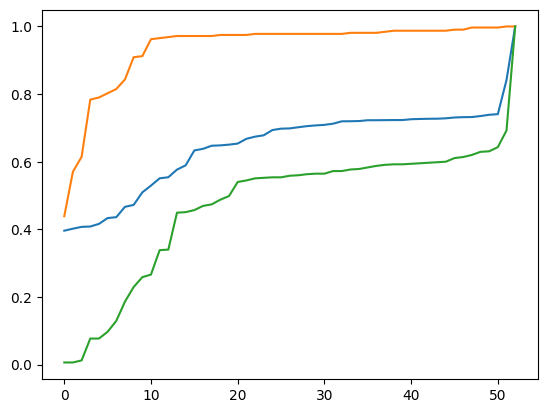

In [18]:
train_final, dev_final, test_final = analyze_annotations(new_train, new_val, new_test, crop=False)

---------- check ----------
sizes - train: (53,) val: (53,) test: (53,)
(0, 0) (0, 0) (0, 0)
set()
---------- clean ----------
(127856, 27) (15849, 27) (16306, 27)
---------- train ----------
annotator head
user_id
39    1475
5     1497
22    1517
54    1521
36    1550
Name: text_id, dtype: int64
annotator tail
user_id
17    2738
49    2752
8     2759
32    3135
59    3725
Name: text_id, dtype: int64
ANNOTATORS
min: 1475 mean: 2412.377358490566 median: 2602.0 max: 3725 all: 127856
TEXTS
min: 1 mean: 4.3562521294718906 median: 2.0 max: 53 all: 127856
---------- dev ----------
annotator head
user_id
1     140
39    182
13    196
4     250
2     252
Name: text_id, dtype: int64
annotator tail
user_id
23    318
30    318
54    318
11    319
18    319
Name: text_id, dtype: int64
ANNOTATORS
min: 140 mean: 299.0377358490566 median: 312.0 max: 319 all: 15849
TEXTS
min: 1 mean: 42.49061662198391 median: 50.0 max: 53 all: 15849
---------- test ----------
annotator head
user_id
54     4
5      4
2

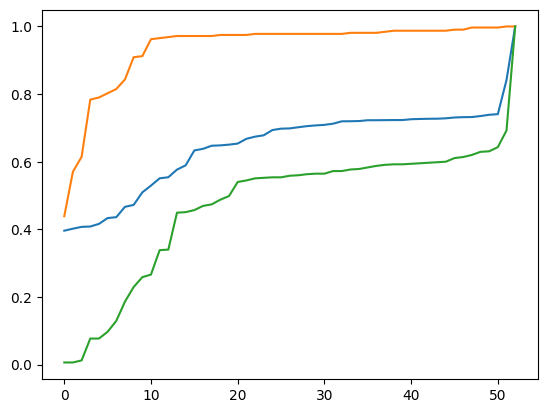

In [19]:
_ = analyze_annotations(train_final, dev_final, test_final, crop=False)

In [20]:
train_final.to_csv(train_path, index=False)
dev_final.to_csv(val_path, index=False)
test_final.to_csv(test_path, index=False)